In [1]:
import sys
sys.path.append("..")
import vesuvius
from vesuvius import Volume
import multiprocessing as mp
from tqdm import tqdm
files = vesuvius.list_files()
import matplotlib.pyplot as plt
import torch


segment_ids = ['20231210121321','20231106155350','20231005123336','20230820203112','20230620230619','20230826170124','20230702185753','20230522215721','20230531193658','20230520175435','20230903193206','20230902141231','20231007101615','20230929220924','recto','verso','20231016151000','20231012184423','20231031143850']

In [2]:
# Initialize list to store ink labels
def get_inklabels_from_id(segment_id):
    inklabels = [] 
    try:
        volume = Volume(int(segment_id))
        inklabels = volume.inklabel
    except Exception as e:
        print(f"Error processing segment {segment_id}: {e}")
        return None
    
    return inklabels

# pull labels in parallel
with mp.Pool(mp.cpu_count()) as pool:
    results = list(tqdm(pool.map(get_inklabels_from_id, segment_ids), total=len(segment_ids)))

print(results)


Error processing segment verso: invalid literal for int() with base 10: 'verso'Error processing segment recto: invalid literal for int() with base 10: 'recto'

An error occurred while initializing the Volume class: URL not found for scroll: None, energy: None, resolution: None, segment: 20231012184423
An error occurred while initializing the Volume class: URL not found for scroll: None, energy: None, resolution: None, segment: 20231031143850Load the canonical scroll 1 with Volume(type="scroll", scroll_id=1, energy=54, resolution=7.91)

Load the canonical scroll 1 with Volume(type="scroll", scroll_id=1, energy=54, resolution=7.91)If loading another part of the same physical scroll use for instance Volume(type="scroll", scroll_id="1b", energy=54, resolution=7.91)

If loading another part of the same physical scroll use for instance Volume(type="scroll", scroll_id="1b", energy=54, resolution=7.91)Load a segment (e.g. 20230827161847) with Volume(type="segment", scroll_id=1, energy=54, reso

100%|██████████| 19/19 [00:00<00:00, 288738.32it/s]

[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(15872, 12544, 3), dtype=uint8), None, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0,

In [3]:
results = [res for res in results if res is not None]  # Filter out None results

In [4]:
for res in results:
    print(res.shape)

(15872, 12544, 3)
(11008, 29952)
(7424, 2816)
(6656, 5632)
(5376, 3840)
(13568, 17408)
(5632, 4608)
(2816, 5888)
(3072, 7936)
(10496, 4096)
(4864, 4096)


In [5]:
results[0] = results[0][:,:,0]  # Use the first result as a reference

In [6]:
for res in results:
    print(res.shape, res.dtype, res.min(), res.max())
    

(15872, 12544) uint8 0 255
(11008, 29952) uint8 0 255
(7424, 2816) uint8 0 255
(6656, 5632) uint8 0 255
(5376, 3840) uint8 0 255
(13568, 17408) uint8 0 255
(5632, 4608) uint8 0 255
(2816, 5888) uint8 0 255
(3072, 7936) uint8 0 255
(10496, 4096) uint8 0 255
(4864, 4096) uint8 0 255


Number of samples created: 106


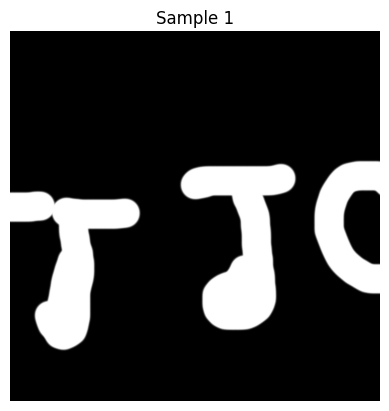

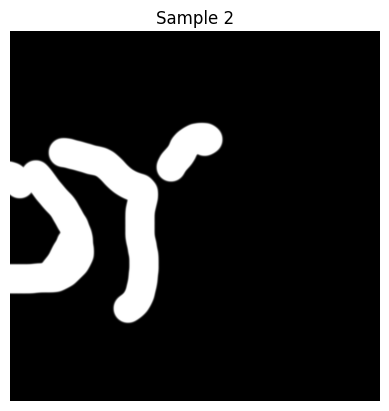

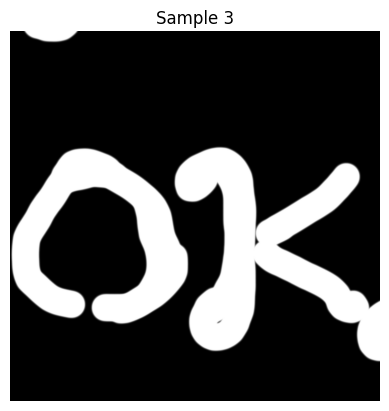

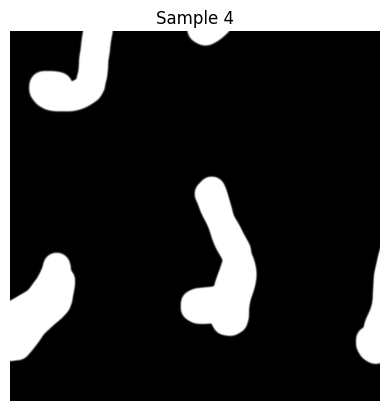

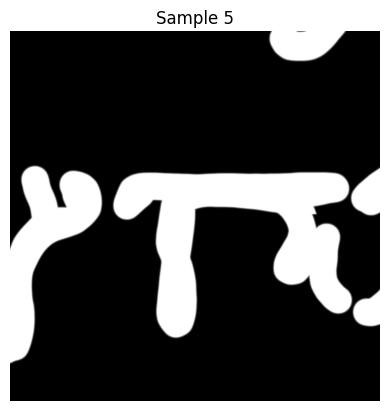

In [7]:
# create a batch of quadratic samples from inklabels
def create_quadratic_samples(inklabels, sample_size=1024):
    samples = []
    for inklabel in inklabels:
        h, w = inklabel.shape
        for i in range(0, h - sample_size + 1, sample_size):
            for j in range(0, w - sample_size + 1, sample_size):
                sample = inklabel[i:i + sample_size, j:j + sample_size]
                if sample.max() > 0:
                    samples.append(sample)
        break
    return samples

# Create samples from the first inklabel
samples = create_quadratic_samples(results)
print(f"Number of samples created: {len(samples)}")
# Visualize some samples
for i in range(min(5, len(samples))):
    plt.imshow(samples[i+10], cmap='gray')
    plt.title(f'Sample {i+1}')
    plt.axis('off')
    plt.show()

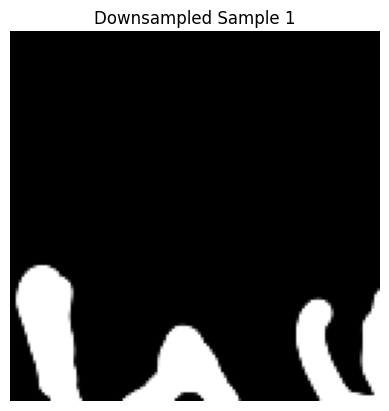

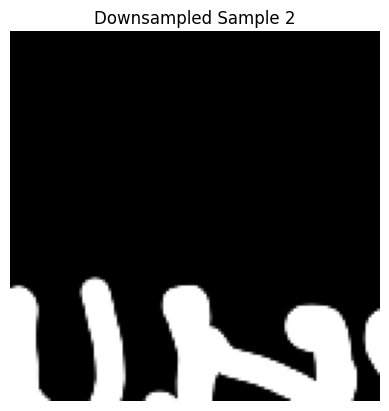

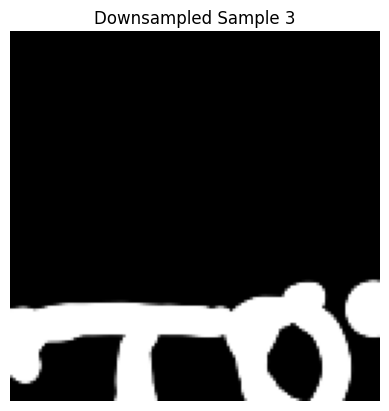

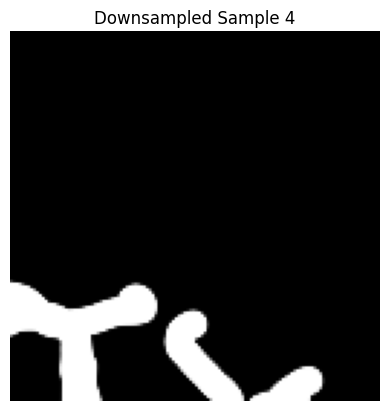

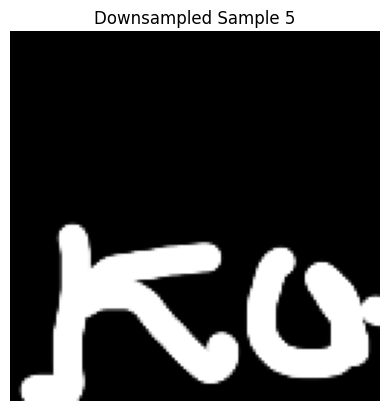

In [ ]:
#downsample the samples to 128x128
def downsample_samples(samples, target_size=(128, 128)):
    downsampled = []
    for sample in samples:
        downsampled_sample = torch.nn.functional.interpolate(
            torch.tensor(sample).unsqueeze(1).float(),
            size=target_size,
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()
        downsampled.append(downsampled_sample)
    return downsampled

#plot 5 downsampled samples
downsampled_samples = downsample_samples(samples)
for i in range(min(5, len(downsampled_samples))):
    plt.imshow(downsampled_samples[i], cmap='gray')
    plt.title(f'Downsampled Sample {i+1}')
    plt.axis('off')
    plt.show()